Running PMCMC: 100%|█████████████████████████████████████| Time: 0:06:37


Final acceptance rate: 0.28
Estimated ρ:         
(true_rho))
Estimated λ:         
(true_lambda_c))
Estimated σ_ε:       
(true_sigma_epsilon))
Estimated σ_ξ:       
(true_sigma_xi))
Estimated σ_κ:       
(true_sigma_kappa))


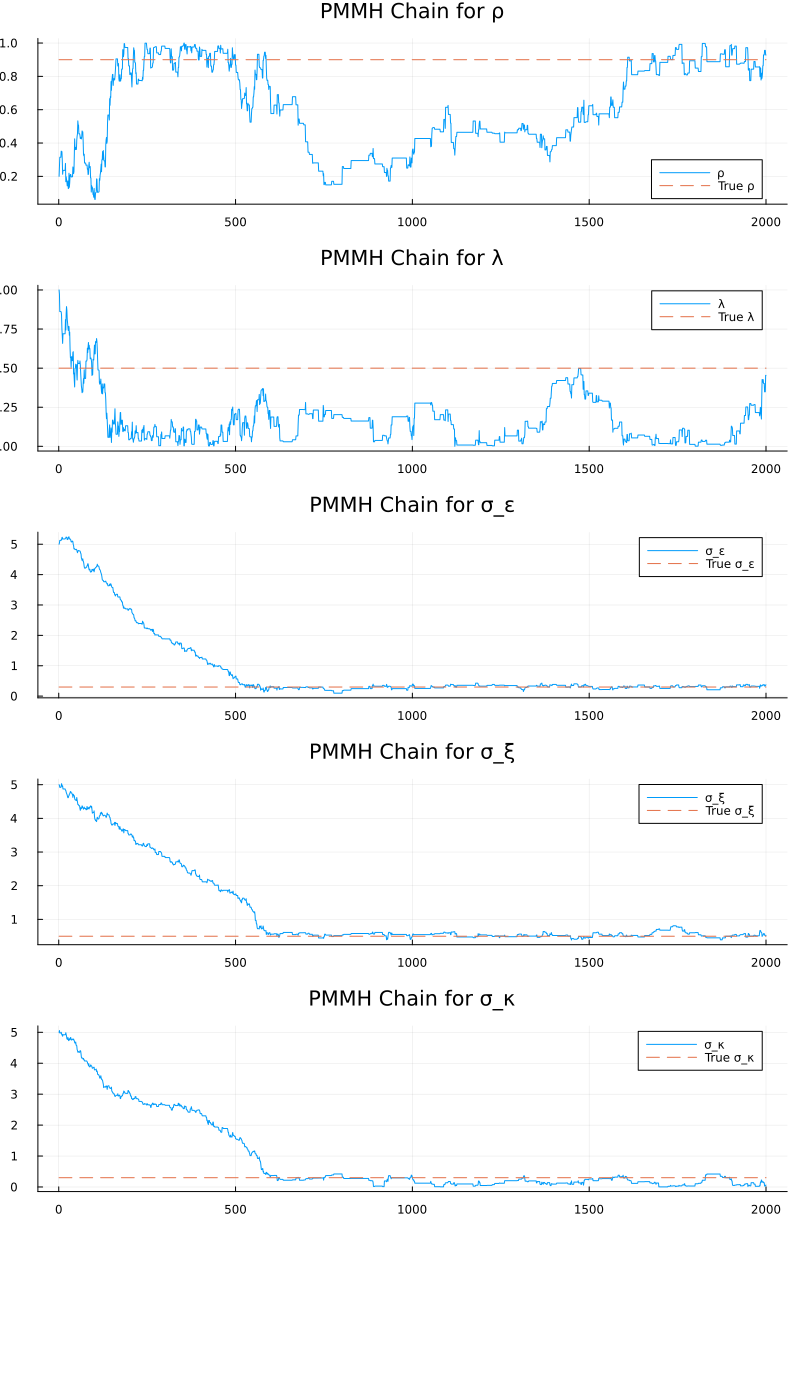

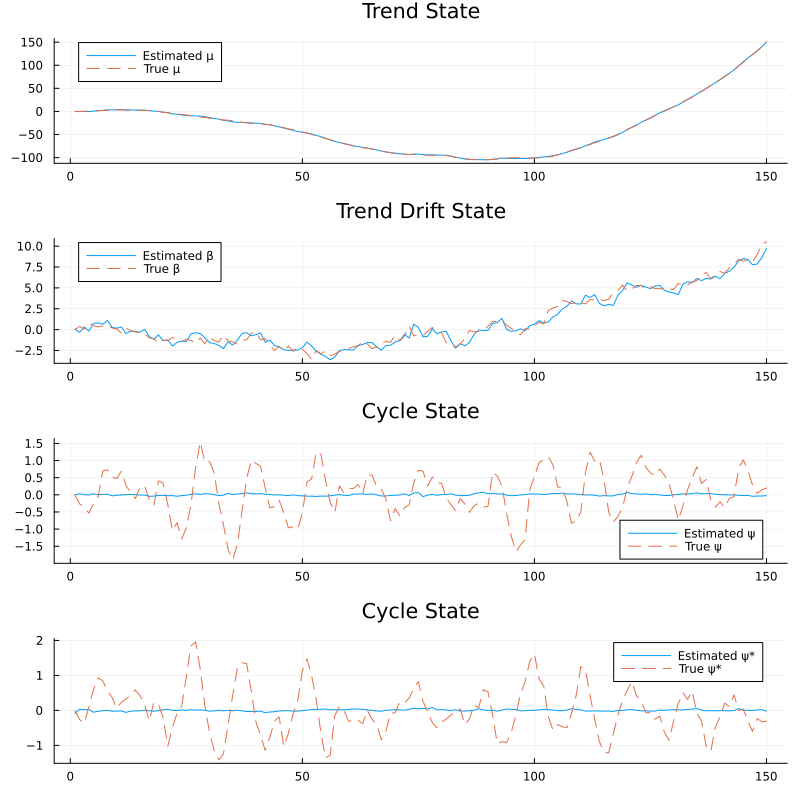

In [1]:


using Random
using Distributions
using StatsBase
using Plots
using ProgressMeter

# ================================
# 1. Generate Synthetic Data for the New Model
# ================================

Random.seed!(42)

# True parameters for the state-space model
true_rho         = 0.9            # damping factor for the cycle (should be in (0,1))
true_lambda_c    = 0.5            # cycle frequency (radians), between 0 and π
true_sigma_epsilon = 0.3          # observation noise std
true_sigma_xi    = 0.5            # trend drift noise std
true_sigma_kappa = 0.3            # cyclical shock noise std

T = 150  # number of time steps

# Allocate arrays for the states and observations
mu_true     = zeros(T)
beta_true   = zeros(T)
psi_true    = zeros(T)
psi_star_true = zeros(T)
y_obs       = zeros(T)

# Initial states (set to zero or small random values)
mu_true[1]      = 0.0
beta_true[1]    = 0.0
psi_true[1]     = 0.0
psi_star_true[1]= 0.0

# Precompute rotation matrix for the cycle
rot = [cos(true_lambda_c) sin(true_lambda_c);
       -sin(true_lambda_c) cos(true_lambda_c)]

# Generate the data recursively
# t = 1 is already set; now simulate for t = 2:T
for t in 2:T
    # Trend updates:
    mu_true[t]   = mu_true[t-1] + beta_true[t-1]
    beta_true[t] = beta_true[t-1] + rand(Normal(0, true_sigma_xi))
    
    # Cycle update:
    # Form the previous cycle state vector.
    cycle_prev = [psi_true[t-1], psi_star_true[t-1]]
    # Draw two independent shocks for the cycle.
    noise = rand(Normal(0, true_sigma_kappa), 2)
    cycle_new = true_rho * (rot * cycle_prev) + noise
    psi_true[t]      = cycle_new[1]
    psi_star_true[t] = cycle_new[2]
    
    # Observation equation:
    y_obs[t] = mu_true[t] + psi_true[t] + rand(Normal(0, true_sigma_epsilon))
end

# ================================
# 2. Particle Filter Function for the New Model
# ================================

"""
    particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)

Runs a particle filter for the state-space model:
  
  Trend:
    μₜ = μₜ₋₁ + βₜ₋₁
    βₜ = βₜ₋₁ + ξₜ, ξₜ ~ N(0, σ_ξ)
  
  Cycle (first order):
    [ψₜ, ψₜ*]' = ρ * R(λ) * [ψₜ₋₁, ψₜ₋₁*]' + [κₜ, κₜ*]', κₜ, κₜ* ~ N(0, σ_κ)
  
  Observation:
    yₜ = μₜ + ψₜ + εₜ, εₜ ~ N(0, σ_ε)

Returns a tuple: (log_likelihood, filtered_means) where filtered_means contains
the estimated trend μₜ at each time step.
"""
function particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)
    T = length(y_obs)
    # Allocate matrices for each state component (dimensions: time x particles)
    particles_mu      = zeros(T, N)
    particles_beta    = zeros(T, N)
    particles_psi     = zeros(T, N)
    particles_psistar = zeros(T, N)
    weights = zeros(T, N)
    filtered_mu = zeros(T)
    filtered_beta = zeros(T)
    filtered_psi = zeros(T)
    filtered_psistar = zeros(T)
    log_likelihood = 0.0

    # Initialization:
    # Assume initial distributions for the states:
    particles_mu[1, :]      = rand(Normal(0,1), N)
    particles_beta[1, :]    = rand(Normal(0,1), N)
    particles_psi[1, :]     = rand(Normal(0,1), N)
    particles_psistar[1, :] = rand(Normal(0,1), N)

    # Weight the initial particles using the observation likelihood:
    for i in 1:N
        mean_obs = particles_mu[1,i] + particles_psi[1,i]
        weights[1, i] = pdf(Normal(mean_obs, σ_ε), y_obs[1])
    end
    wsum = sum(weights[1, :])
    weights[1, :] ./= wsum
    log_likelihood += log(wsum / N)
    filtered_mu[1] = sum(particles_mu[1, :] .* weights[1, :])
    filtered_beta[1] = sum(particles_beta[1, :] .* weights[1, :])
    filtered_psi[1] = sum(particles_psi[1, :] .* weights[1, :])
    filtered_psistar[1] = sum(particles_psistar[1, :] .* weights[1, :])

    # Precompute the rotation matrix for the cycle update
    rot = [cos(λ) sin(λ); -sin(λ) cos(λ)]

    for t in 2:T
        # Resample indices according to weights from time t-1
        indices = sample(1:N, Weights(weights[t-1, :]), N, replace=true)

        for i in 1:N
            # Retrieve the resampled states:
            μ_prev   = particles_mu[t-1, indices[i]]
            β_prev   = particles_beta[t-1, indices[i]]
            ψ_prev   = particles_psi[t-1, indices[i]]
            ψs_prev  = particles_psistar[t-1, indices[i]]

            # Trend update:
            μ_new = μ_prev + β_prev
            β_new = β_prev + rand(Normal(0, σ_ξ))

            # Cycle update:
            cycle_prev = [ψ_prev, ψs_prev]
            noise = rand(Normal(0, σ_κ), 2)
            cycle_new = ρ * (rot * cycle_prev) + noise
            ψ_new  = cycle_new[1]
            ψs_new = cycle_new[2]

            # Store new states:
            particles_mu[t, i]      = μ_new
            particles_beta[t, i]    = β_new
            particles_psi[t, i]     = ψ_new
            particles_psistar[t, i] = ψs_new

            # Compute the likelihood for the observation at time t:
            mean_obs = μ_new + ψ_new
            weights[t, i] = pdf(Normal(mean_obs, σ_ε), y_obs[t])
        end

        # Normalize weights and update log-likelihood:
        wsum = sum(weights[t, :])
        if wsum == 0
            weights[t, :] .= 1.0 / N
        else
            weights[t, :] ./= wsum
        end
        log_likelihood += log(wsum / N)
        filtered_mu[t] = sum(particles_mu[t, :] .* weights[t, :])
        filtered_beta[t] = sum(particles_beta[t, :] .* weights[t, :])
        filtered_psi[t] = sum(particles_psi[t, :] .* weights[t, :])
        filtered_psistar[t] = sum(particles_psistar[t, :] .* weights[t, :])

    end

    return log_likelihood, filtered_mu, filtered_beta, filtered_psi, filtered_psistar
end

# ================================
# 3. PMMH to Estimate (ρ, λ, σ_ε, σ_ξ, σ_κ)
# ================================

function PMMH(y_obs; n_iter=3000, N=500)
    # Arrays to store samples
    rho_samples         = zeros(n_iter)
    lambda_samples      = zeros(n_iter)
    sigma_epsilon_samples = zeros(n_iter)
    sigma_xi_samples    = zeros(n_iter)
    sigma_kappa_samples = zeros(n_iter)
    loglikelihoods      = zeros(n_iter)

    # Initialize parameters (choose valid starting values)
    rho_current         = 0.2
    lambda_current      = 1.0       # in radians, between 0 and π
    sigma_epsilon_current = 5.0
    sigma_xi_current    = 5.0
    sigma_kappa_current = 5.0

    ll_current, _, _, _,_ = particle_filter(y_obs, rho_current, lambda_current, sigma_epsilon_current, sigma_xi_current, sigma_kappa_current; N=N)

    # Store initial values:
    rho_samples[1]         = rho_current
    lambda_samples[1]      = lambda_current
    sigma_epsilon_samples[1] = sigma_epsilon_current
    sigma_xi_samples[1]    = sigma_xi_current
    sigma_kappa_samples[1] = sigma_kappa_current
    loglikelihoods[1]      = ll_current

    # Proposal standard deviations for random-walk proposals
    prop_std_rho    = 0.05
    prop_std_lambda = 0.05
    prop_std_ε      = 0.05
    prop_std_ξ      = 0.05
    prop_std_κ      = 0.05

    accept_count = 0
    @showprogress "Running PMCMC:" for i in 2:n_iter
        # Propose new parameters via a random-walk:
        rho_proposal    = rho_current + randn() * prop_std_rho
        lambda_proposal = lambda_current + randn() * prop_std_lambda
        sigma_epsilon_proposal = sigma_epsilon_current + randn() * prop_std_ε
        sigma_xi_proposal    = sigma_xi_current + randn() * prop_std_ξ
        sigma_kappa_proposal = sigma_kappa_current + randn() * prop_std_κ

        # Enforce parameter constraints:
        if (rho_proposal <= 0 || rho_proposal >= 1 ||
            lambda_proposal <= 0 || lambda_proposal >= π ||
            sigma_epsilon_proposal <= 0 || sigma_xi_proposal <= 0 || sigma_kappa_proposal <= 0)
            # Reject proposal by keeping current parameters
            rho_samples[i]         = rho_current
            lambda_samples[i]      = lambda_current
            sigma_epsilon_samples[i] = sigma_epsilon_current
            sigma_xi_samples[i]    = sigma_xi_current
            sigma_kappa_samples[i] = sigma_kappa_current
            loglikelihoods[i]      = ll_current
            continue
        end

        # Run particle filter for the proposed parameters:
        ll_proposal, _ = particle_filter(y_obs, rho_proposal, lambda_proposal, sigma_epsilon_proposal, sigma_xi_proposal, sigma_kappa_proposal; N=N)

        # Compute log-priors
        log_prior_current = 0
        log_prior_proposal = 0

        log_alpha = (ll_proposal + log_prior_proposal) - (ll_current + log_prior_current)
        if log(rand()) < log_alpha
            rho_current         = rho_proposal
            lambda_current      = lambda_proposal
            sigma_epsilon_current = sigma_epsilon_proposal
            sigma_xi_current    = sigma_xi_proposal
            sigma_kappa_current = sigma_kappa_proposal
            ll_current          = ll_proposal
            accept_count       += 1
        end

        rho_samples[i]         = rho_current
        lambda_samples[i]      = lambda_current
        sigma_epsilon_samples[i] = sigma_epsilon_current
        sigma_xi_samples[i]    = sigma_xi_current
        sigma_kappa_samples[i] = sigma_kappa_current
        loglikelihoods[i]      = ll_current

#         if mod(i, 500) == 0
#             println("Iteration 
# (round(rho_current, digits=3)), λ = 
# (round(sigma_epsilon_current, digits=3)), σ_ξ = 
# (round(sigma_kappa_current, digits=3)), acceptance = $(round(accept_count/i, digits=3))")
#         end
    end

    println("Final acceptance rate: $(round(accept_count/n_iter, digits=3))")
    return rho_samples, lambda_samples, sigma_epsilon_samples, sigma_xi_samples, sigma_kappa_samples, loglikelihoods
end

# ================================
# 4. Run PMMH and Estimate Parameters
# ================================

n_iter = 2000
rho_chain, lambda_chain, sigma_epsilon_chain, sigma_xi_chain, sigma_kappa_chain, ll_chain = 
    PMMH(y_obs; n_iter=n_iter, N=2000)

# Discard burn-in (e.g., first 20000 iterations)
burn_in = 1000
est_rho         = mean(rho_chain[burn_in+1:end])
est_lambda      = mean(lambda_chain[burn_in+1:end])
est_sigma_epsilon = mean(sigma_epsilon_chain[burn_in+1:end])
est_sigma_xi    = mean(sigma_xi_chain[burn_in+1:end])
est_sigma_kappa = mean(sigma_kappa_chain[burn_in+1:end])

println("Estimated ρ:         
(true_rho))")
println("Estimated λ:         
(true_lambda_c))")
println("Estimated σ_ε:       
(true_sigma_epsilon))")
println("Estimated σ_ξ:       
(true_sigma_xi))")
println("Estimated σ_κ:       
(true_sigma_kappa))")

# ================================
# 5. Obtain State Estimates Using the Particle Filter
# ================================

ll_final, mu, beta, psi, psi_star = particle_filter(y_obs, est_rho, est_lambda, est_sigma_epsilon, est_sigma_xi, est_sigma_kappa; N=1000)

# ================================
# 6. Plotting the Results
# ================================

# Plot parameter chains
p1 = plot(rho_chain, label="ρ", title="PMMH Chain for ρ")
plot!(p1, fill(true_rho, length(rho_chain)), label="True ρ", linestyle=:dash)

p2 = plot(lambda_chain, label="λ", title="PMMH Chain for λ")
plot!(p2, fill(true_lambda_c, length(lambda_chain)), label="True λ", linestyle=:dash)

p3 = plot(sigma_epsilon_chain, label="σ_ε", title="PMMH Chain for σ_ε")
plot!(p3, fill(true_sigma_epsilon, length(sigma_epsilon_chain)), label="True σ_ε", linestyle=:dash)

p4 = plot(sigma_xi_chain, label="σ_ξ", title="PMMH Chain for σ_ξ")
plot!(p4, fill(true_sigma_xi, length(sigma_xi_chain)), label="True σ_ξ", linestyle=:dash)

p5 = plot(sigma_kappa_chain, label="σ_κ", title="PMMH Chain for σ_κ")
plot!(p5, fill(true_sigma_kappa, length(sigma_kappa_chain)), label="True σ_κ", linestyle=:dash)


# Combine all plots and display
plot(p1, p2, p3, p4, p5, layout=(6,1), size=(800, 1400))
display(plot(p1, p2, p3, p4, p5, layout=(6,1), size=(800, 1400)))


# Plot the true and estimated states
p6 = plot(1:T, mu, label="Estimated μ", title="Trend State")
plot!(p6, 1:T, mu_true, label="True μ", linestyle=:dash)

p7 = plot(1:T, beta, label="Estimated β", title="Trend Drift State")
plot!(p7, 1:T, beta_true, label="True β", linestyle=:dash)

p8 = plot(1:T, psi, label="Estimated ψ", title="Cycle State")
plot!(p8, 1:T, psi_true, label="True ψ", linestyle=:dash)

p9 = plot(1:T, psi_star, label="Estimated ψ*", title="Cycle State")
plot!(p9, 1:T, psi_star_true, label="True ψ*", linestyle=:dash)

# Combine all plots and display
plot(p6, p7, p8, p9, layout=(4,1), size=(800, 800))
display(plot(p6, p7, p8, p9, layout=(4,1), size=(800, 800)))


Running Adaptive PMCMC: 100%|████████████████████████████| Time: 0:06:58


Final acceptance rate: 24.9%
Estimated ρ: 0.27839566603702964 (True: 0.9)
Estimated λ: 1.0945028443371445 (True: 0.5)
Estimated σₑ: 0.21142350445284303 (True: 0.3)
Estimated σ_ξ: 0.5710288717734465 (True: 0.5)
Estimated σ_κ: 0.2544914448892396 (True: 0.3)


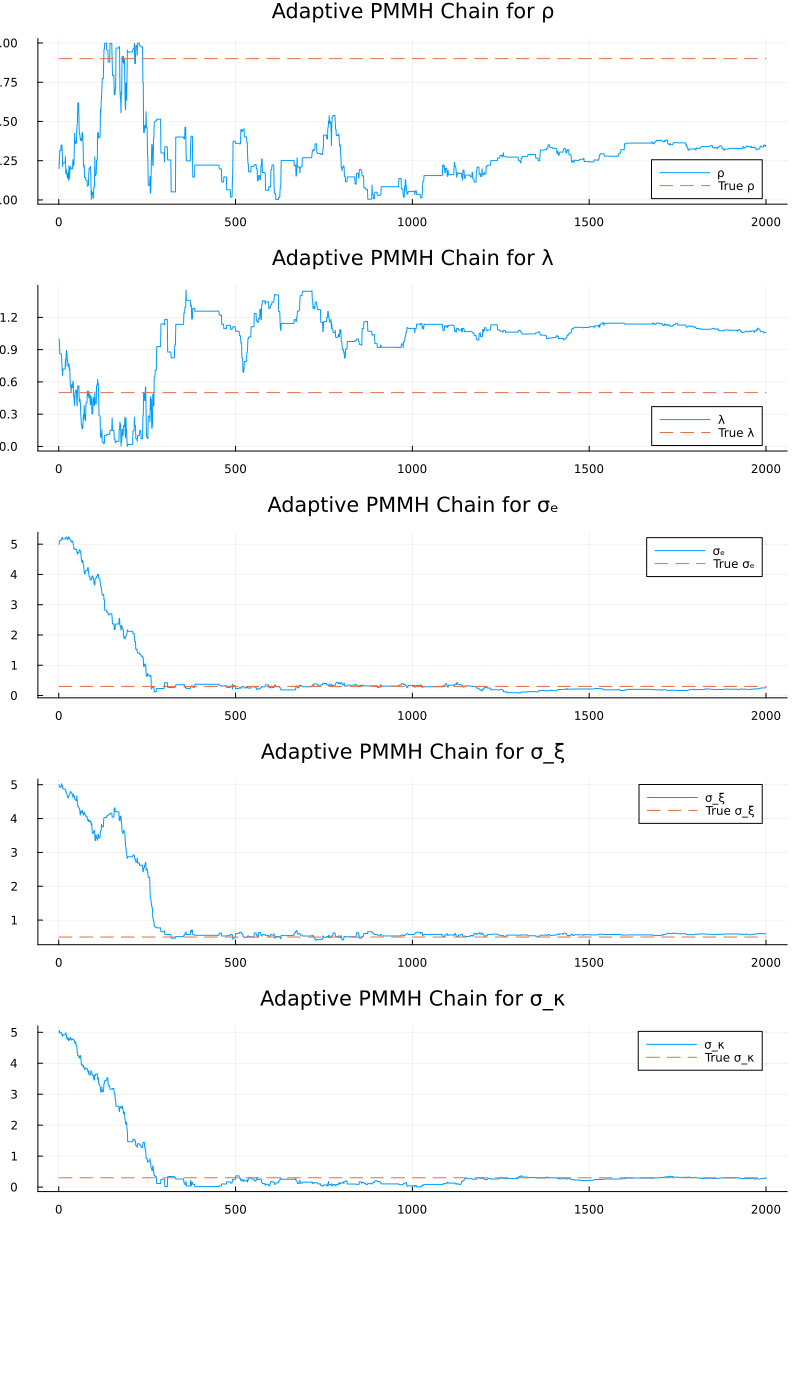

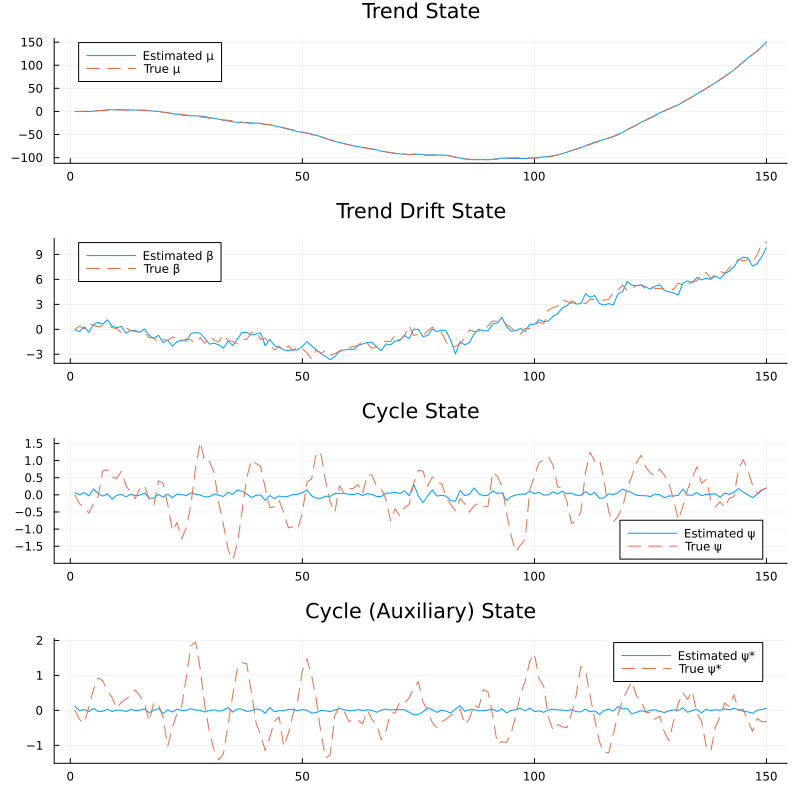

In [2]:
using Random
using Distributions
using StatsBase
using Plots
using ProgressMeter

# ================================
# 1. Generate Synthetic Data for the New Model
# ================================

Random.seed!(42)

# True parameters for the state-space model
true_rho         = 0.9            # damping factor for the cycle (should be in (0,1))
true_lambda_c    = 0.5            # cycle frequency (radians), between 0 and π
true_sigma_epsilon = 0.3          # observation noise std
true_sigma_xi    = 0.5            # trend drift noise std
true_sigma_kappa = 0.3            # cyclical shock noise std

T = 150  # number of time steps

# Allocate arrays for the states and observations
mu_true       = zeros(T)
beta_true     = zeros(T)
psi_true      = zeros(T)
psi_star_true = zeros(T)
y_obs         = zeros(T)

# Initial states (set to zero or small random values)
mu_true[1]       = 0.0
beta_true[1]     = 0.0
psi_true[1]      = 0.0
psi_star_true[1] = 0.0

# Precompute rotation matrix for the cycle
rot = [cos(true_lambda_c) sin(true_lambda_c);
       -sin(true_lambda_c) cos(true_lambda_c)]

# Generate the data recursively
for t in 2:T
    # Trend updates:
    mu_true[t]   = mu_true[t-1] + beta_true[t-1]
    beta_true[t] = beta_true[t-1] + rand(Normal(0, true_sigma_xi))
    
    # Cycle update:
    cycle_prev = [psi_true[t-1], psi_star_true[t-1]]
    noise = rand(Normal(0, true_sigma_kappa), 2)
    cycle_new = true_rho * (rot * cycle_prev) + noise
    psi_true[t]      = cycle_new[1]
    psi_star_true[t] = cycle_new[2]
    
    # Observation equation:
    y_obs[t] = mu_true[t] + psi_true[t] + rand(Normal(0, true_sigma_epsilon))
end

# ================================
# 2. Particle Filter Function for the New Model
# ================================

"""
    particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)

Runs a particle filter for the state-space model:
  
  Trend:
    μₜ = μₜ₋₁ + βₜ₋₁
    βₜ = βₜ₋₁ + ξₜ, ξₜ ~ N(0, σ_ξ)
  
  Cycle (first order):
    [ψₜ, ψₜ*]' = ρ * R(λ) * [ψₜ₋₁, ψₜ₋₁*]' + [κₜ, κₜ*]', κₜ, κₜ* ~ N(0, σ_κ)
  
  Observation:
    yₜ = μₜ + ψₜ + εₜ, εₜ ~ N(0, σ_ε)

Returns a tuple: (log_likelihood, filtered_means, filtered_beta, filtered_ψ, filtered_ψs)
"""
function particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)
    T = length(y_obs)
    # Allocate matrices for each state component (dimensions: time x particles)
    particles_mu      = zeros(T, N)
    particles_beta    = zeros(T, N)
    particles_psi     = zeros(T, N)
    particles_psistar = zeros(T, N)
    weights = zeros(T, N)
    filtered_mu      = zeros(T)
    filtered_beta    = zeros(T)
    filtered_psi     = zeros(T)
    filtered_psistar = zeros(T)
    log_likelihood   = 0.0

    # Initialization:
    particles_mu[1, :]      = rand(Normal(0,1), N)
    particles_beta[1, :]    = rand(Normal(0,1), N)
    particles_psi[1, :]     = rand(Normal(0,1), N)
    particles_psistar[1, :] = rand(Normal(0,1), N)

    # Weight the initial particles using the observation likelihood:
    for i in 1:N
        mean_obs = particles_mu[1,i] + particles_psi[1,i]
        weights[1, i] = pdf(Normal(mean_obs, σ_ε), y_obs[1])
    end
    wsum = sum(weights[1, :])
    weights[1, :] ./= wsum
    log_likelihood += log(wsum / N)
    filtered_mu[1]      = sum(particles_mu[1, :] .* weights[1, :])
    filtered_beta[1]    = sum(particles_beta[1, :] .* weights[1, :])
    filtered_psi[1]     = sum(particles_psi[1, :] .* weights[1, :])
    filtered_psistar[1] = sum(particles_psistar[1, :] .* weights[1, :])

    # Precompute the rotation matrix for the cycle update
    rot = [cos(λ) sin(λ); -sin(λ) cos(λ)]

    for t in 2:T
        # Resample indices according to weights from time t-1
        indices = sample(1:N, Weights(weights[t-1, :]), N, replace=true)

        for i in 1:N
            μ_prev  = particles_mu[t-1, indices[i]]
            β_prev  = particles_beta[t-1, indices[i]]
            ψ_prev  = particles_psi[t-1, indices[i]]
            ψs_prev = particles_psistar[t-1, indices[i]]

            # Trend update:
            μ_new = μ_prev + β_prev
            β_new = β_prev + rand(Normal(0, σ_ξ))

            # Cycle update:
            cycle_prev = [ψ_prev, ψs_prev]
            noise = rand(Normal(0, σ_κ), 2)
            cycle_new = ρ * (rot * cycle_prev) + noise
            ψ_new  = cycle_new[1]
            ψs_new = cycle_new[2]

            # Store new states:
            particles_mu[t, i]      = μ_new
            particles_beta[t, i]    = β_new
            particles_psi[t, i]     = ψ_new
            particles_psistar[t, i] = ψs_new

            # Compute the likelihood for the observation at time t:
            mean_obs = μ_new + ψ_new
            weights[t, i] = pdf(Normal(mean_obs, σ_ε), y_obs[t])
        end

        # Normalize weights and update log-likelihood:
        wsum = sum(weights[t, :])
        if wsum == 0
            weights[t, :] .= 1.0 / N
        else
            weights[t, :] ./= wsum
        end
        log_likelihood += log(wsum / N)
        filtered_mu[t]      = sum(particles_mu[t, :] .* weights[t, :])
        filtered_beta[t]    = sum(particles_beta[t, :] .* weights[t, :])
        filtered_psi[t]     = sum(particles_psi[t, :] .* weights[t, :])
        filtered_psistar[t] = sum(particles_psistar[t, :] .* weights[t, :])
    end

    return log_likelihood, filtered_mu, filtered_beta, filtered_psi, filtered_psistar
end

# ================================
# 3. Adaptive PMMH to Estimate (ρ, λ, σₑ, σ_ξ, σ_κ)
# ================================

function PMMH_adaptive(y_obs; n_iter=3000, N=500, adapt_interval=50, target_accept=0.3)
    # Arrays to store samples
    rho_samples           = zeros(n_iter)
    lambda_samples        = zeros(n_iter)
    sigma_epsilon_samples = zeros(n_iter)
    sigma_xi_samples      = zeros(n_iter)
    sigma_kappa_samples   = zeros(n_iter)
    loglikelihoods        = zeros(n_iter)

    # Initialize parameters (choose valid starting values)
    rho_current           = 0.2
    lambda_current        = 1.0       # in radians, between 0 and π
    sigma_epsilon_current = 5.0
    sigma_xi_current      = 5.0
    sigma_kappa_current   = 5.0

    ll_current, _, _, _, _ = particle_filter(y_obs, rho_current, lambda_current,
                                             sigma_epsilon_current, sigma_xi_current,
                                             sigma_kappa_current; N=N)

    # Store initial values:
    rho_samples[1]           = rho_current
    lambda_samples[1]        = lambda_current
    sigma_epsilon_samples[1] = sigma_epsilon_current
    sigma_xi_samples[1]      = sigma_xi_current
    sigma_kappa_samples[1]   = sigma_kappa_current
    loglikelihoods[1]        = ll_current

    # Proposal standard deviations (initial values)
    prop_std_rho    = 0.05
    prop_std_lambda = 0.05
    prop_std_ε      = 0.05
    prop_std_ξ      = 0.05
    prop_std_κ      = 0.05

    accept_count = 0
    block_accept_count = 0

    @showprogress "Running Adaptive PMCMC:" for i in 2:n_iter
        # Propose new parameters via a random-walk:
        rho_proposal    = rho_current + randn() * prop_std_rho
        lambda_proposal = lambda_current + randn() * prop_std_lambda
        sigma_epsilon_proposal = sigma_epsilon_current + randn() * prop_std_ε
        sigma_xi_proposal      = sigma_xi_current + randn() * prop_std_ξ
        sigma_kappa_proposal   = sigma_kappa_current + randn() * prop_std_κ

        # Enforce parameter constraints:
        if (rho_proposal <= 0 || rho_proposal >= 1 ||
            lambda_proposal <= 0 || lambda_proposal >= π ||
            sigma_epsilon_proposal <= 0 || sigma_xi_proposal <= 0 || sigma_kappa_proposal <= 0)
            # Reject proposal by keeping current parameters:
            rho_samples[i]           = rho_current
            lambda_samples[i]        = lambda_current
            sigma_epsilon_samples[i] = sigma_epsilon_current
            sigma_xi_samples[i]      = sigma_xi_current
            sigma_kappa_samples[i]   = sigma_kappa_current
            loglikelihoods[i]        = ll_current
        else
            # Run particle filter for the proposed parameters:
            ll_proposal, _ = particle_filter(y_obs, rho_proposal, lambda_proposal,
                                             sigma_epsilon_proposal, sigma_xi_proposal,
                                             sigma_kappa_proposal; N=N)

            # Compute log acceptance ratio (assuming flat priors)
            log_alpha = ll_proposal - ll_current

            if log(rand()) < log_alpha
                # Accept proposal:
                rho_current           = rho_proposal
                lambda_current        = lambda_proposal
                sigma_epsilon_current = sigma_epsilon_proposal
                sigma_xi_current      = sigma_xi_proposal
                sigma_kappa_current   = sigma_kappa_proposal
                ll_current            = ll_proposal

                accept_count       += 1
                block_accept_count += 1
            end

            # Store current state:
            rho_samples[i]           = rho_current
            lambda_samples[i]        = lambda_current
            sigma_epsilon_samples[i] = sigma_epsilon_current
            sigma_xi_samples[i]      = sigma_xi_current
            sigma_kappa_samples[i]   = sigma_kappa_current
            loglikelihoods[i]        = ll_current
        end

        # Adapt proposal standard deviations every 'adapt_interval' iterations
        if mod(i, adapt_interval) == 0
            block_accept_rate = block_accept_count / adapt_interval
            # Update each proposal std deviation multiplicatively:
            prop_std_rho    *= exp(block_accept_rate - target_accept)
            prop_std_lambda *= exp(block_accept_rate - target_accept)
            prop_std_ε      *= exp(block_accept_rate - target_accept)
            prop_std_ξ      *= exp(block_accept_rate - target_accept)
            prop_std_κ      *= exp(block_accept_rate - target_accept)
            block_accept_count = 0  # reset for the next block
        end
    end

    println("Final acceptance rate: $(round(accept_count/n_iter*100, digits=3))%")
    return rho_samples, lambda_samples, sigma_epsilon_samples, sigma_xi_samples, sigma_kappa_samples, loglikelihoods
end

# ================================
# 4. Run Adaptive PMMH and Estimate Parameters
# ================================

n_iter = 2000
rho_chain, lambda_chain, sigma_epsilon_chain, sigma_xi_chain, sigma_kappa_chain, ll_chain = 
    PMMH_adaptive(y_obs; n_iter=n_iter, N=2000, adapt_interval=50, target_accept=0.3)

# Discard burn-in (e.g., first 1000 iterations)
burn_in = 1000
est_rho           = mean(rho_chain[burn_in+1:end])
est_lambda        = mean(lambda_chain[burn_in+1:end])
est_sigma_epsilon = mean(sigma_epsilon_chain[burn_in+1:end])
est_sigma_xi      = mean(sigma_xi_chain[burn_in+1:end])
est_sigma_kappa   = mean(sigma_kappa_chain[burn_in+1:end])

println("Estimated ρ: ", est_rho, " (True: ", true_rho, ")")
println("Estimated λ: ", est_lambda, " (True: ", true_lambda_c, ")")
println("Estimated σₑ: ", est_sigma_epsilon, " (True: ", true_sigma_epsilon, ")")
println("Estimated σ_ξ: ", est_sigma_xi, " (True: ", true_sigma_xi, ")")
println("Estimated σ_κ: ", est_sigma_kappa, " (True: ", true_sigma_kappa, ")")

# ================================
# 5. Obtain State Estimates Using the Particle Filter
# ================================

ll_final, mu, beta, psi, psi_star = particle_filter(y_obs, est_rho, est_lambda, est_sigma_epsilon, est_sigma_xi, est_sigma_kappa; N=1000)

# ================================
# 6. Plotting the Results
# ================================

# Plot parameter chains
p1 = plot(rho_chain, label="ρ", title="Adaptive PMMH Chain for ρ")
plot!(p1, fill(true_rho, length(rho_chain)), label="True ρ", linestyle=:dash)

p2 = plot(lambda_chain, label="λ", title="Adaptive PMMH Chain for λ")
plot!(p2, fill(true_lambda_c, length(lambda_chain)), label="True λ", linestyle=:dash)

p3 = plot(sigma_epsilon_chain, label="σₑ", title="Adaptive PMMH Chain for σₑ")
plot!(p3, fill(true_sigma_epsilon, length(sigma_epsilon_chain)), label="True σₑ", linestyle=:dash)

p4 = plot(sigma_xi_chain, label="σ_ξ", title="Adaptive PMMH Chain for σ_ξ")
plot!(p4, fill(true_sigma_xi, length(sigma_xi_chain)), label="True σ_ξ", linestyle=:dash)

p5 = plot(sigma_kappa_chain, label="σ_κ", title="Adaptive PMMH Chain for σ_κ")
plot!(p5, fill(true_sigma_kappa, length(sigma_kappa_chain)), label="True σ_κ", linestyle=:dash)

plot(p1, p2, p3, p4, p5, layout=(6,1), size=(800, 1400))
display(plot(p1, p2, p3, p4, p5, layout=(6,1), size=(800, 1400)))

# Plot the true and estimated states
p6 = plot(1:T, mu, label="Estimated μ", title="Trend State")
plot!(p6, 1:T, mu_true, label="True μ", linestyle=:dash)

p7 = plot(1:T, beta, label="Estimated β", title="Trend Drift State")
plot!(p7, 1:T, beta_true, label="True β", linestyle=:dash)

p8 = plot(1:T, psi, label="Estimated ψ", title="Cycle State")
plot!(p8, 1:T, psi_true, label="True ψ", linestyle=:dash)

p9 = plot(1:T, psi_star, label="Estimated ψ*", title="Cycle (Auxiliary) State")
plot!(p9, 1:T, psi_star_true, label="True ψ*", linestyle=:dash)

plot(p6, p7, p8, p9, layout=(4,1), size=(800, 800))
display(plot(p6, p7, p8, p9, layout=(4,1), size=(800, 800)))
